<a href="https://colab.research.google.com/github/nastaranmarzban/BGAT-and-GAT-Jupyter-notebook/blob/main/GAT_5classes_150nodes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mount to gdrive to read data, adjacency matrix, p_link and labels.

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


# Install pandas to read csv files from gdrive. Install torch and numpy which are packages that are needed durind coding.

In [ ]:
!pip install pandas
import pandas as pd
import torch
import numpy as np

# Load data which are processed in preprocessing data_5classdes_150nodes.ipynb file.

In [ ]:
path = F"/gdrive/MyDrive/5classes_150.sim/data.pt"
Data = torch.load(path)
Data

{'x': tensor([[-1.1996, -0.5363, -1.0551,  ...,  1.0784, -0.1099,  0.6258],
         [ 1.9717,  1.5424,  1.0104,  ..., -0.6536,  2.3499, -0.1438],
         [-0.3870,  0.3711, -1.0519,  ..., -0.6554,  2.1013, -0.8379],
         ...,
         [-1.4236, -1.3652, -1.1248,  ..., -1.0004,  0.0174,  1.6165],
         [-0.5597, -2.0122,  0.3641,  ...,  0.2956, -0.0478, -0.5333],
         [ 0.5681, -0.7714,  0.7749,  ..., -0.5489, -1.6281,  1.2040]]),
 'edge_index': tensor([[  0,   0,   0,  ..., 149, 149, 149],
         [ 21,  57,  97,  ..., 109, 128, 141]]),
 'y': tensor([2, 1, 3, 4, 4, 1, 0, 4, 4, 2, 4, 3, 1, 0, 2, 4, 2, 1, 3, 0, 0, 1, 2, 1,
         1, 2, 3, 0, 2, 4, 2, 1, 0, 0, 0, 3, 0, 0, 1, 1, 3, 0, 0, 1, 1, 4, 4, 1,
         3, 4, 0, 4, 3, 3, 3, 3, 4, 2, 2, 2, 4, 4, 3, 2, 1, 3, 3, 0, 3, 0, 4, 4,
         0, 0, 1, 2, 4, 1, 0, 4, 1, 3, 2, 0, 0, 4, 1, 3, 0, 4, 2, 2, 3, 2, 4, 3,
         3, 2, 1, 4, 4, 2, 4, 2, 0, 0, 4, 2, 3, 0, 0, 3, 1, 4, 3, 1, 1, 1, 1, 3,
         2, 1, 2, 4, 1, 0, 1, 3, 

# Gather some statistics about the graph.

In [ ]:
print(f'Number of nodes: {Data["x"].size(0)}')
print(f'Number of features: {Data["x"].size(1)}')
print(f'Number of classes: {torch.numel(torch.unique(Data["y"],sorted=True))}')
print(f'Number of edges: {Data["edge_index"].size(1)}')
print(f'Average node degree: {Data["edge_index"].size(1) / Data["x"].size(0):.2f}')
print(f'Number of training nodes: {Data["train_mask"].sum()}')
print(f'Number of testing nodes: {Data["test_mask"].sum()}')
print(f'Training node label rate: {int(Data["train_mask"].sum()) /  Data["x"].size(0):.2f}')

Number of nodes: 150
Number of features: 500
Number of classes: 5
Number of edges: 954
Average node degree: 6.36
Number of training nodes: 120
Number of testing nodes: 15
Training node label rate: 0.80


# Install torch_geometic.

In [ ]:
import os
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.1.0+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 53.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 19.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import torch_geometric
from torch_geometric.nn import MessagePassing
import torch.nn.functional as F
from torch_geometric.utils import add_self_loops
from torch_geometric.nn import GATConv

# Creating message passing network.

In [ ]:
class Myconv(torch.nn.Module):
    def __init__(self, dropout_rate=0.5):
        super().__init__()
        torch.manual_seed(2)
        self.conv1 = GATConv(in_channels=500, out_channels=8)
        self.dropout1 = torch.nn.Dropout(dropout_rate)
        self.conv2 = GATConv(8, 6)
        self.dropout2 = torch.nn.Dropout(dropout_rate)
        self.conv3 = GATConv(6, 5)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = F.tanh(h)
        h = self.dropout1(h)
        h = self.conv2(h, edge_index)
        h = F.tanh(h)
        h = self.dropout2(h)
        h = self.conv3(h, edge_index)
        return h

# Create an instance of the model
model = Myconv(dropout_rate=0.5)
print(model)

Myconv(
  (conv1): GATConv(500, 8, heads=1)
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv2): GATConv(8, 6, heads=1)
  (dropout2): Dropout(p=0.5, inplace=False)
  (conv3): GATConv(6, 5, heads=1)
)


# We take a look at the node embeddings produced by our GNN (before training).

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

def visualize(h):
    z = TSNE(n_components = 2, random_state = 0).fit_transform(h.detach().numpy())
    plt.figure(figsize = (6,4),  dpi = 120)
    sns.scatterplot(x = z[:, 0], y = z[:, 1], hue = Data["y"], palette=sns.color_palette("bright",5)).set(title = "First scenario data T-SNE projection before training (GAT)")

Embedding shape: [150, 5]


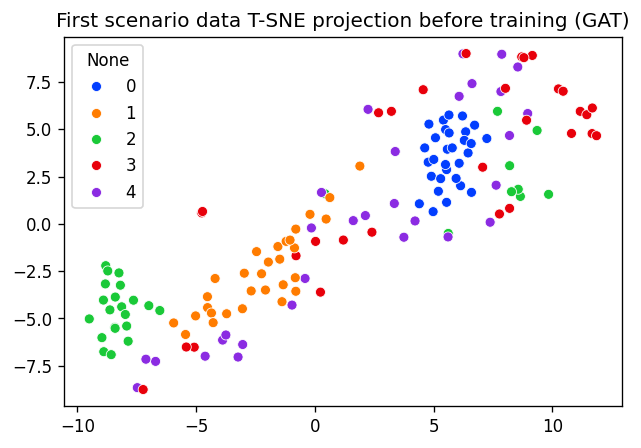

In [ ]:
model = Myconv()
h = model(Data["x"], Data["edge_index"])

print(f'Embedding shape: {list(h.shape)}')
visualize(h)

# Start training the model.

In [ ]:
model = Myconv()
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(),  lr = 0.005)  # Define optimizer, an object for updating parameters
#loss = loss + weight decay parameter * L2 norm of the weights, 1) To prevent overfitting 2) To keep the weights small and avoid exploding gradient

def train(Data):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out = model(Data["x"], Data["edge_index"])
    train_loss = criterion(out[Data["train_mask"]], Data["y"][Data["train_mask"]])  # Compute the loss solely based on the training nodes.
    train_loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return train_loss


def val(Data):
      model.eval()
      with torch.no_grad():
        out = model(Data["x"], Data["edge_index"])
        val_loss = criterion(out[Data["val_mask"]], Data["y"][Data["val_mask"]])
        #pred = out.argmax(dim=1)
        #test_correct = pred[Data["val_mask"]] == Data["y"][Data["val_mask"]]  # Check against ground-truth labels.
        #test_acc = int(test_correct.sum()) / int(Data["val_mask"].sum())  # Derive ratio of correct predictions.
        return val_loss


In [ ]:
train_loss_ = []
val_loss_ = []

for epoch in range(1, 651):

  epoch_train_loss = []
  epoch_val_loss = []
  train_loss = train(Data)
  val_loss = val(Data)






  epoch_train_loss.append(train_loss.item())
  epoch_val_loss.append(val_loss.item())






  val_loss_.append(sum(epoch_val_loss)/len(epoch_val_loss))
  train_loss_.append(sum(epoch_train_loss)/len(epoch_train_loss))
  print(epoch,'Train Loss: %.3f | val Loss: %.3f'%( train_loss,val_loss))

1 Train Loss: 1.657 | val Loss: 1.381
2 Train Loss: 1.536 | val Loss: 1.283
3 Train Loss: 1.450 | val Loss: 1.219
4 Train Loss: 1.390 | val Loss: 1.200
5 Train Loss: 1.323 | val Loss: 1.198
6 Train Loss: 1.295 | val Loss: 1.193
7 Train Loss: 1.450 | val Loss: 1.171
8 Train Loss: 1.326 | val Loss: 1.155
9 Train Loss: 1.349 | val Loss: 1.133
10 Train Loss: 1.345 | val Loss: 1.110
11 Train Loss: 1.331 | val Loss: 1.096
12 Train Loss: 1.187 | val Loss: 1.085
13 Train Loss: 1.264 | val Loss: 1.080
14 Train Loss: 1.137 | val Loss: 1.077
15 Train Loss: 1.174 | val Loss: 1.071
16 Train Loss: 1.204 | val Loss: 1.063
17 Train Loss: 1.063 | val Loss: 1.054
18 Train Loss: 1.064 | val Loss: 1.048
19 Train Loss: 1.158 | val Loss: 1.043
20 Train Loss: 1.088 | val Loss: 1.033
21 Train Loss: 1.209 | val Loss: 1.017
22 Train Loss: 1.027 | val Loss: 1.002
23 Train Loss: 1.102 | val Loss: 0.985
24 Train Loss: 1.011 | val Loss: 0.969
25 Train Loss: 0.995 | val Loss: 0.959
26 Train Loss: 1.160 | val Loss: 0

# Visualize train loss and val loss.


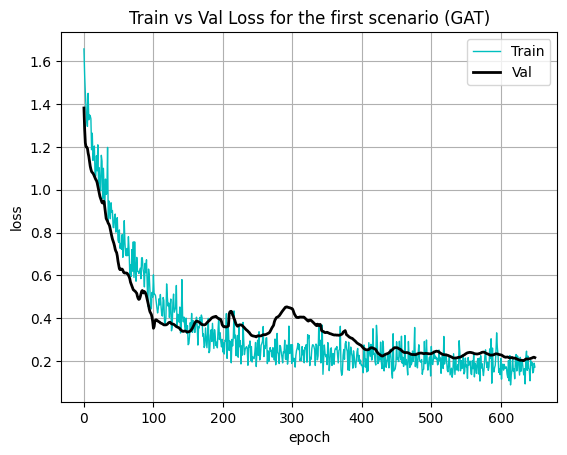

In [ ]:
plt.plot(train_loss_, "c", linewidth = 1)
plt.plot(val_loss_, "k", linewidth = 2)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train','Val'])
plt.title('Train vs Val Loss for the first scenario (GAT)')
plt.grid()
plt.show()

# Compute the accuracy of the model.

In [ ]:
def test(Data):
      model.eval()
      with torch.no_grad():
        out = model(Data["x"], Data["edge_index"])
        pred = out.argmax(dim = 1)
        test_correct = pred[Data["test_mask"]] == Data["y"][Data["test_mask"]]  # Check against ground-truth labels.
        test_acc = int(test_correct.sum()) / int(Data["test_mask"].sum())  # Derive ratio of correct predictions.
        return test_acc


In [ ]:
test_acc = test(Data)
print(f'Test Accuracy: {100*test_acc:.2f}')

Test Accuracy: 86.67


# We take a look at the node embeddings produced by our GNN (after training).

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

def visualize(h):
    z = TSNE(n_components = 2, random_state = 0).fit_transform(h.detach().numpy())
    plt.figure(figsize = (6,4),  dpi = 120)
    sns.scatterplot(x = z[:, 0], y = z[:, 1], hue = Data["y"], palette=sns.color_palette("bright",5)).set(title = "First scenario data T-SNE projection after training (GAT)")

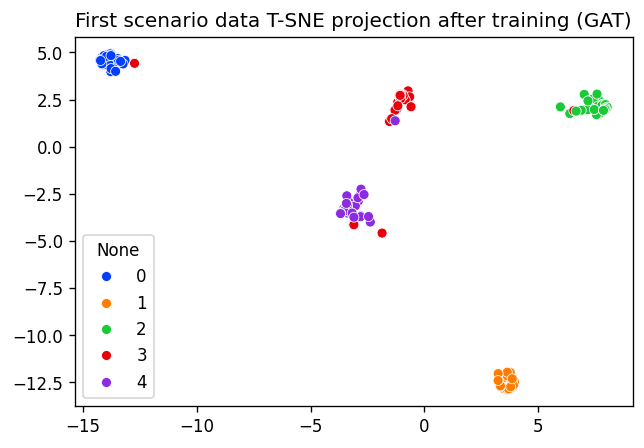

In [ ]:
model.eval()
out = model(Data["x"], Data["edge_index"])
visualize(out)

# Confusion matrix.

In [ ]:
pred_t = out.argmax(dim=1)
pred_t

tensor([2, 1, 3, 4, 4, 1, 0, 4, 4, 3, 4, 3, 1, 0, 2, 4, 2, 1, 3, 0, 0, 1, 2, 1,
        1, 2, 3, 0, 2, 4, 2, 1, 0, 0, 0, 4, 0, 0, 1, 1, 3, 0, 0, 1, 1, 4, 4, 1,
        3, 4, 0, 4, 3, 3, 3, 3, 4, 2, 2, 2, 4, 4, 3, 2, 1, 3, 3, 0, 3, 0, 4, 4,
        0, 0, 1, 2, 4, 1, 0, 4, 1, 3, 2, 0, 0, 4, 1, 3, 0, 4, 2, 2, 3, 2, 4, 0,
        3, 2, 1, 4, 4, 2, 4, 2, 0, 0, 4, 2, 4, 0, 0, 3, 1, 3, 3, 1, 1, 1, 1, 3,
        2, 1, 2, 4, 1, 0, 1, 2, 0, 2, 1, 3, 3, 2, 2, 4, 3, 4, 2, 3, 0, 0, 2, 3,
        1, 1, 2, 2, 4, 0])

In [ ]:
Data["y"]

tensor([2, 1, 3, 4, 4, 1, 0, 4, 4, 2, 4, 3, 1, 0, 2, 4, 2, 1, 3, 0, 0, 1, 2, 1,
        1, 2, 3, 0, 2, 4, 2, 1, 0, 0, 0, 3, 0, 0, 1, 1, 3, 0, 0, 1, 1, 4, 4, 1,
        3, 4, 0, 4, 3, 3, 3, 3, 4, 2, 2, 2, 4, 4, 3, 2, 1, 3, 3, 0, 3, 0, 4, 4,
        0, 0, 1, 2, 4, 1, 0, 4, 1, 3, 2, 0, 0, 4, 1, 3, 0, 4, 2, 2, 3, 2, 4, 3,
        3, 2, 1, 4, 4, 2, 4, 2, 0, 0, 4, 2, 3, 0, 0, 3, 1, 4, 3, 1, 1, 1, 1, 3,
        2, 1, 2, 4, 1, 0, 1, 3, 0, 2, 1, 3, 3, 2, 2, 4, 3, 4, 2, 3, 0, 0, 2, 3,
        1, 1, 2, 2, 4, 0])

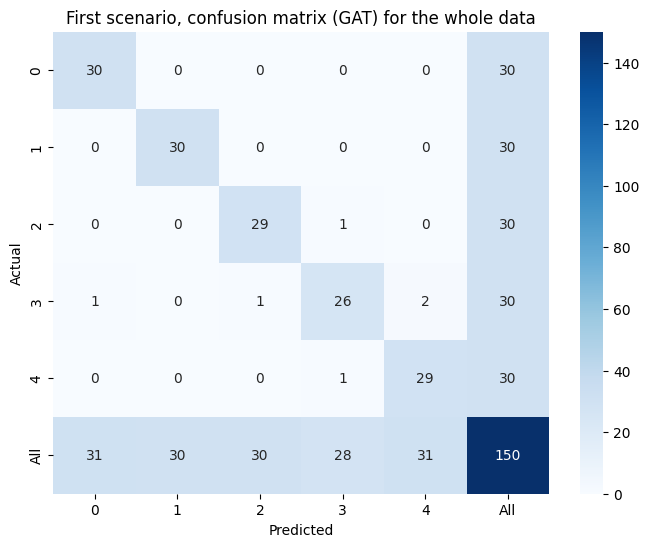

In [ ]:
import seaborn as sn
confusion_matrix = pd.crosstab(Data['y'], pred_t, rownames=['Actual'], colnames = ['Predicted'], margins = True)
plt.figure(figsize=(8, 6))
sn.heatmap(confusion_matrix, annot=True,  cmap="Blues", fmt='g')
plt.title('First scenario, confusion matrix (GAT) for the whole data')
plt.show()

In [ ]:
pred = pred_t[Data["test_mask"]]

In [ ]:
act = Data["y"][Data["test_mask"]]

In [ ]:
data = {'y_Actual':    act,
        'y_Predicted':pred
        }

df = pd.DataFrame(data, columns = ['y_Actual','y_Predicted'])
df

,y_Actual,y_Predicted
0,1,1
1,2,2
2,2,2
3,3,4
4,4,4
5,0,0
6,2,2
7,4,4
8,0,0
9,4,4


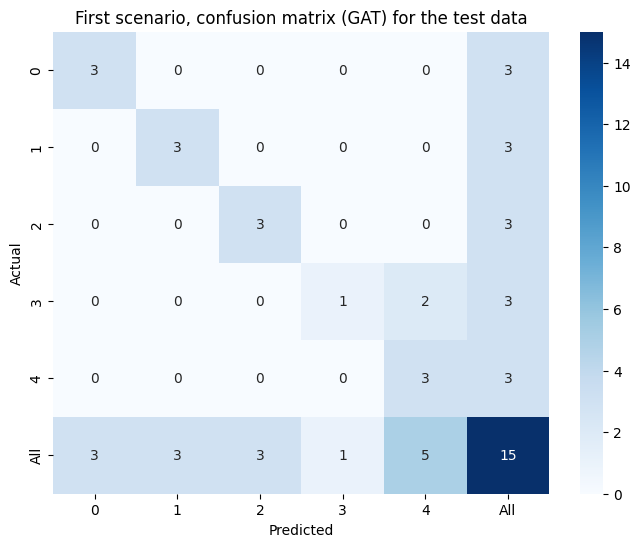

In [ ]:
import seaborn as sn
confusion_matrix = pd.crosstab(act, pred, rownames=['Actual'], colnames = ['Predicted'], margins = True)
plt.figure(figsize=(8, 6))
sn.heatmap(confusion_matrix, annot=True,  cmap="Blues", fmt='g')
plt.title('First scenario, confusion matrix (GAT) for the test data')
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score, f1_score, recall_score
# Assuming these are your predicted and true labels in PyTorch tensors
out = model(Data["x"], Data["edge_index"])
pred = out.argmax(dim = 1)
y_pred_np = pred[Data["test_mask"]]

y_true_np = Data["y"][Data["test_mask"]]
# Calculate F-score and recall per class
f_score = f1_score(y_true_np, y_pred_np, average='macro')
recall = recall_score(y_true_np, y_pred_np, average='macro')

print(f'F-score: {f_score:.3f}')
print(f'Recall: {recall:.3f}')


F-score: 0.850
Recall: 0.867


In [ ]:
from sklearn.metrics import cohen_kappa_score

# Calculate Cohen's Kappa
kappa = cohen_kappa_score(y_true_np, y_pred_np)

print(f'Cohen\'s Kappa: {kappa:.3f}')

Cohen's Kappa: 0.833


In [ ]:
from sklearn.metrics import precision_score
average_precision = precision_score(y_true_np, y_pred_np, average='macro')
print(f'Average Precision: {average_precision:.3f}')

Average Precision: 0.920
